<a href="https://colab.research.google.com/github/gcosma/COP509/blob/main/LabSolutions/Lab_Exercise_(No_2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Lab Exercise (No. 2)**

**Task Overview**

Your task is to use the cleaned ArtReviews dataset and the ArtRatings(classes) and repeat the Lab sheet to create a Sentiment analysis model as follows (and as explained in the lab tutorial).

1. First sentiment analysis model
2. Making a prediction for new reviews
3. Comparing word scoring models

###***pre-work1: mount drive***

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


###***pre-work2: set datasets***

In [ ]:
data_path = "/content/drive/My Drive/Colab Notebooks/21COP509/LabDatasets/"
!ls "/content/drive/My Drive/Colab Notebooks/21COP509/LabDatasets/"

# select datasets
datasets = 'Arts5000' # ArtsAll, Arts5000


if datasets == 'ArtsAll':
  # Arts all
  data_all_reviews = 'ArtsReviews.txt'
  data_all_ratings = 'ArtsRatings.txt'
  data_train_reviews = 'ArtsReviews_train.txt'
  data_test_reviews = 'ArtsReviews_test.txt'
  data_train_ratings = 'ArtsRatings_train.txt'
  data_test_ratings = 'ArtsRatings_test.txt'
else:
  # Arts 5000
  data_all_reviews = 'Reduced_ArtsReviews_5000.txt'
  data_all_ratings = 'Reduced_ArtsRatings_5000.txt'
  data_train_reviews = 'ArtsReviews_5000_train.txt'
  data_test_reviews = 'ArtsReviews_5000_test.txt'
  data_train_ratings = 'ArtsRatings_5000_train.txt'
  data_test_ratings = 'ArtsRatings_5000_test.txt'

ArtsRatings_5000_test.txt   ArtsReviews_5000_train.txt	Reduced_ArtsRatings_5000.txt
ArtsRatings_5000_train.txt  glove.6B.100d.txt		Reduced_ArtsReviews_5000.txt
ArtsReviews_5000_test.txt   metamorphosis_clean.txt	review_polarity


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

details of numbers in Arts 5000:

train:
5.0:  805,
4.0:  803,
3.0:  785,
2.0:  791,
1.0:  816

test:
5.0:  195,
4.0:  197,
3.0:  215,
2.0:  209,
1.0:  184

##**1. First Sentiment Analysis Model**


In [ ]:
# Installation commands - run these first
!pip install nltk
!pip install tensorflow

In [ ]:
# Required imports
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
import numpy as np
from string import punctuation
from os import listdir
from collections import Counter
from nltk.corpus import stopwords
import random

# Download required NLTK data (only need once)
nltk.download('stopwords')

# File handling functions
def load_doc(filename):
    """Load document from file"""
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

def save_list(lines, filename):
    """Save list to file"""
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

def load_doc_lines(filename):
    """Load document as lines"""
    file = open(filename, 'rt')
    lines = list()
    while True:
        line = file.readline()
        if not line:
            break
        lines.append(line.strip("\n"))
    file.close()
    return lines

# Text processing functions
def clean_doc(doc):
    """Clean document text"""
    tokens = doc.split()
    tokens = [word.lower() for word in tokens]
    table = str.maketrans('', '', punctuation)
    tokens = [w.translate(table) for w in tokens]
    tokens = [word for word in tokens if word.isalpha()]
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if w not in stop_words]
    tokens = [word for word in tokens if len(word) > 1]
    return tokens

def add_doc_to_vocab(filename, vocab):
    """Add document words to vocabulary"""
    doc = load_doc(filename)
    tokens = clean_doc(doc)
    vocab.update(tokens)

def doc_to_line(doc, vocab):
    """Convert document to line of tokens"""
    tokens = clean_doc(doc)
    tokens = [w for w in tokens if w in vocab]
    return ' '.join(tokens)

def process_docs(files, vocab):
    """Process all documents"""
    lines = list()
    for doc in files:
        line = doc_to_line(doc, vocab)
        lines.append(line)
    return lines

def random_sample(num1, num2):
    """Split data into train and test sets"""
    dataList = list(range(num1))
    TrainIndex = []
    for i in range(num2):
        randIndex = int(random.uniform(0, len(dataList)))
        TrainIndex.append(dataList[randIndex])
        del(dataList[randIndex])
    return TrainIndex, dataList  # dataList becomes TestIndex

# Build vocabulary
vocab = Counter()
add_doc_to_vocab(data_path + data_train_reviews, vocab)
print(f"Vocabulary size: {len(vocab)}")
print("Top 50 words:", vocab.most_common(50))

# Filter vocabulary by minimum occurrence
min_occurrence = 2
tokens = [k for k, c in vocab.items() if c >= min_occurrence]
print(f"Filtered vocabulary size: {len(tokens)}")

# Save and load vocabulary
save_list(tokens, 'vocab.txt')
vocab = set(load_doc(vocab_filename).split())

# Load training and test data
ArRe_train_lines = load_doc_lines(data_path + data_train_reviews)
ArRa_train_lines = np.loadtxt(data_path + data_train_ratings, dtype=float)
ArRe_test_lines = load_doc_lines(data_path + data_test_reviews)
ArRa_test_lines = np.loadtxt(data_path + data_test_ratings, dtype=float)

# Process documents
docs = process_docs(ArRe_train_lines, vocab)

# Create and fit tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(docs)

# Encode training data
Xtrain = tokenizer.texts_to_matrix(docs, mode='freq')
print(f"Training data shape: {Xtrain.shape}")

# Process and encode test data
docs = process_docs(ArRe_test_lines, vocab)
Xtest = tokenizer.texts_to_matrix(docs, mode='freq')
print(f"Test data shape: {Xtest.shape}")

n_words = Xtest.shape[1]
print(f"Vocabulary size: {n_words}")

# Prepare labels
ytrain = np.array(ArRa_train_lines) - 1
ytest = np.array(ArRa_test_lines) - 1
ytrain = to_categorical(ytrain)
ytest = to_categorical(ytest)

# Define and compile model
model = Sequential()
model.add(Dense(50, input_shape=(n_words,), activation='relu'))
model.add(Dense(5, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

# Train model
model.fit(Xtrain, ytrain, epochs=20, verbose=2)

# Evaluate model
loss, acc = model.evaluate(Xtest, ytest, verbose=0)
print(f'Test Accuracy: {acc*100:.2f}%')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Vocabulary size: 14744
Top 50 words: [('machine', 1914), ('use', 1445), ('one', 1416), ('would', 1286), ('get', 1021), ('like', 993), ('product', 957), ('good', 942), ('paper', 895), ('great', 864), ('sewing', 840), ('well', 781), ('time', 723), ('used', 702), ('dont', 696), ('work', 674), ('bought', 653), ('really', 638), ('little', 616), ('even', 604), ('thread', 583), ('make', 542), ('much', 527), ('easy', 508), ('im', 502), ('buy', 499), ('also', 499), ('quality', 493), ('price', 485), ('got', 471), ('first', 468), ('made', 455), ('could', 438), ('back', 418), ('ive', 414), ('scissors', 402), ('using', 395), ('small', 391), ('need', 389), ('better', 389), ('two', 385), ('still', 381), ('set', 375), ('nice', 364), ('plastic', 361), ('way', 359), ('new', 355), ('item', 347), ('didnt', 347), ('love', 346)]
Filtered vocabulary size: 6734
Training data shape: (4000, 6735)
Test data shape: (1000, 6735)
Vocabulary size: 6735


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
125/125 - 2s - 15ms/step - accuracy: 0.2005 - loss: 0.5965
Epoch 2/20
125/125 - 1s - 7ms/step - accuracy: 0.3050 - loss: 0.4980
Epoch 3/20
125/125 - 1s - 10ms/step - accuracy: 0.4958 - loss: 0.4908
Epoch 4/20
125/125 - 1s - 7ms/step - accuracy: 0.5587 - loss: 0.4781
Epoch 5/20
125/125 - 1s - 10ms/step - accuracy: 0.5975 - loss: 0.4576
Epoch 6/20
125/125 - 1s - 7ms/step - accuracy: 0.6400 - loss: 0.4350
Epoch 7/20
125/125 - 2s - 14ms/step - accuracy: 0.6640 - loss: 0.4131
Epoch 8/20
125/125 - 2s - 17ms/step - accuracy: 0.6875 - loss: 0.3933
Epoch 9/20
125/125 - 1s - 11ms/step - accuracy: 0.7253 - loss: 0.3751
Epoch 10/20
125/125 - 2s - 15ms/step - accuracy: 0.7430 - loss: 0.3582
Epoch 11/20
125/125 - 2s - 18ms/step - accuracy: 0.7638 - loss: 0.3420
Epoch 12/20
125/125 - 1s - 7ms/step - accuracy: 0.7803 - loss: 0.3267
Epoch 13/20
125/125 - 1s - 7ms/step - accuracy: 0.7975 - loss: 0.3120
Epoch 14/20
125/125 - 1s - 10ms/step - accuracy: 0.8127 - loss: 0.2975
Epoch 15/20
125/125 

Arts All Test Accuracy: 68.709791

Arts 5000 Test Accuracy: 48.100001

##**2. Making a Prediction for New Reviews**

In [ ]:
# classify a review as ratings (0,1,2,3,4)
def predict_sentiment(review, vocab, tokenizer, model):
	# clean
	tokens = clean_doc(review)
	# filter by vocab
	tokens = [w for w in tokens if w in vocab]
	# convert to line
	line = ' '.join(tokens)
	# encode
	encoded = tokenizer.texts_to_matrix([line], mode='freq')
	# prediction
	yhat = model.predict(encoded, verbose=0)
	return numpy.argmax(yhat[0]) + 1

# test positive text
text = 'I really enjoy these scissors for my inspiration books!'
print(predict_sentiment(text, vocab, tokenizer, model))

text = 'I like these scissors!'
print(predict_sentiment(text, vocab, tokenizer, model))

# test negative text
text = 'I hate these scissors!'
print(predict_sentiment(text, vocab, tokenizer, model))

text = 'Bad scissors!'
print(predict_sentiment(text, vocab, tokenizer, model))

4
4
3
1


##**3. Comparing Word Scoring Methods**

# Text Encoding Modes in Keras Tokenizer

Each mode represents a different way of converting text into numerical features:

## 1. Binary Mode
- Simplest encoding where each word is marked as either present (1) or absent (0)
- Ignores how many times a word appears
- Good for simple presence/absence analysis

Formula:
binary(w,d) = 1 if word w appears in document d, else 0

## 2. Count Mode
- Records the raw count of each word's appearances
- Preserves exact frequency information
- Can be biased by document length differences

Formula:
count(w,d) = number of times word w appears in document d

## 3. TF-IDF Mode (Term Frequency-Inverse Document Frequency)
- Balances word frequency with word rarity across all documents
- Gives higher weight to words that are frequent in this document but rare overall
- Good for finding distinctive/important words

Formula:
tf-idf(w,d) = tf(w,d) × log(N/df(w))

where:
tf(w,d) = frequency of word w in document d
N = total number of documents
df(w) = number of documents containing word w

## 4. Frequency Mode
- Word counts normalized by document length
- Accounts for different document sizes
- Good for comparing documents of different lengths

Formula:
freq(w,d) = count(w,d) / total_words(d)

These encodings are tested in our model evaluation to determine which works best for our specific classification task.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Vocabulary size: 14744
Top 50 words: [('machine', 1914), ('use', 1445), ('one', 1416), ('would', 1286), ('get', 1021), ('like', 993), ('product', 957), ('good', 942), ('paper', 895), ('great', 864), ('sewing', 840), ('well', 781), ('time', 723), ('used', 702), ('dont', 696), ('work', 674), ('bought', 653), ('really', 638), ('little', 616), ('even', 604), ('thread', 583), ('make', 542), ('much', 527), ('easy', 508), ('im', 502), ('buy', 499), ('also', 499), ('quality', 493), ('price', 485), ('got', 471), ('first', 468), ('made', 455), ('could', 438), ('back', 418), ('ive', 414), ('scissors', 402), ('using', 395), ('small', 391), ('need', 389), ('better', 389), ('two', 385), ('still', 381), ('set', 375), ('nice', 364), ('plastic', 361), ('way', 359), ('new', 355), ('item', 347), ('didnt', 347), ('love', 346)]
Filtered vocabulary size: 6734

Evaluating binary mode:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
125/125 - 2s - 14ms/step - accuracy: 0.3877 - loss: 1.4773
Epoch 2/15
125/125 - 1s - 10ms/step - accuracy: 0.6768 - loss: 1.0021
Epoch 3/15
125/125 - 1s - 7ms/step - accuracy: 0.8227 - loss: 0.6550
Epoch 4/15
125/125 - 1s - 7ms/step - accuracy: 0.9018 - loss: 0.4305
Epoch 5/15
125/125 - 1s - 10ms/step - accuracy: 0.9438 - loss: 0.2872
Epoch 6/15
125/125 - 1s - 12ms/step - accuracy: 0.9705 - loss: 0.1945
Epoch 7/15
125/125 - 1s - 12ms/step - accuracy: 0.9833 - loss: 0.1350
Epoch 8/15
125/125 - 2s - 17ms/step - accuracy: 0.9915 - loss: 0.0959
Epoch 9/15
125/125 - 1s - 10ms/step - accuracy: 0.9960 - loss: 0.0699
Epoch 10/15
125/125 - 1s - 10ms/step - accuracy: 0.9980 - loss: 0.0518
Epoch 11/15
125/125 - 1s - 10ms/step - accuracy: 0.9992 - loss: 0.0393
Epoch 12/15
125/125 - 1s - 10ms/step - accuracy: 0.9998 - loss: 0.0306
Epoch 13/15
125/125 - 1s - 6ms/step - accuracy: 0.9998 - loss: 0.0242
Epoch 14/15
125/125 - 1s - 10ms/step - accuracy: 1.0000 - loss: 0.0194
Epoch 15/15
125/12

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
125/125 - 2s - 14ms/step - accuracy: 0.3980 - loss: 1.4687
Epoch 2/15
125/125 - 1s - 10ms/step - accuracy: 0.6975 - loss: 0.9799
Epoch 3/15
125/125 - 1s - 7ms/step - accuracy: 0.8260 - loss: 0.6459
Epoch 4/15
125/125 - 1s - 10ms/step - accuracy: 0.9018 - loss: 0.4292
Epoch 5/15
125/125 - 1s - 10ms/step - accuracy: 0.9440 - loss: 0.2908
Epoch 6/15
125/125 - 1s - 10ms/step - accuracy: 0.9663 - loss: 0.2002
Epoch 7/15
125/125 - 2s - 14ms/step - accuracy: 0.9820 - loss: 0.1407
Epoch 8/15
125/125 - 2s - 18ms/step - accuracy: 0.9908 - loss: 0.1008
Epoch 9/15
125/125 - 1s - 6ms/step - accuracy: 0.9952 - loss: 0.0735
Epoch 10/15
125/125 - 1s - 10ms/step - accuracy: 0.9983 - loss: 0.0546
Epoch 11/15
125/125 - 1s - 10ms/step - accuracy: 0.9990 - loss: 0.0413
Epoch 12/15
125/125 - 1s - 10ms/step - accuracy: 0.9998 - loss: 0.0321
Epoch 13/15
125/125 - 1s - 10ms/step - accuracy: 0.9998 - loss: 0.0253
Epoch 14/15
125/125 - 1s - 10ms/step - accuracy: 1.0000 - loss: 0.0203
Epoch 15/15
125/1

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
125/125 - 2s - 14ms/step - accuracy: 0.3587 - loss: 1.4721
Epoch 2/15
125/125 - 1s - 10ms/step - accuracy: 0.8350 - loss: 0.6379
Epoch 3/15
125/125 - 1s - 10ms/step - accuracy: 0.9440 - loss: 0.2890
Epoch 4/15
125/125 - 1s - 10ms/step - accuracy: 0.9835 - loss: 0.1329
Epoch 5/15
125/125 - 1s - 10ms/step - accuracy: 0.9955 - loss: 0.0693
Epoch 6/15
125/125 - 1s - 10ms/step - accuracy: 0.9987 - loss: 0.0397
Epoch 7/15
125/125 - 2s - 14ms/step - accuracy: 0.9998 - loss: 0.0253
Epoch 8/15
125/125 - 2s - 20ms/step - accuracy: 1.0000 - loss: 0.0172
Epoch 9/15
125/125 - 1s - 8ms/step - accuracy: 1.0000 - loss: 0.0124
Epoch 10/15
125/125 - 1s - 10ms/step - accuracy: 1.0000 - loss: 0.0093
Epoch 11/15
125/125 - 1s - 7ms/step - accuracy: 1.0000 - loss: 0.0072
Epoch 12/15
125/125 - 1s - 7ms/step - accuracy: 1.0000 - loss: 0.0058
Epoch 13/15
125/125 - 1s - 11ms/step - accuracy: 1.0000 - loss: 0.0047
Epoch 14/15
125/125 - 1s - 9ms/step - accuracy: 1.0000 - loss: 0.0039
Epoch 15/15
125/125

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
125/125 - 2s - 14ms/step - accuracy: 0.2965 - loss: 1.6014
Epoch 2/15
125/125 - 1s - 10ms/step - accuracy: 0.5033 - loss: 1.5364
Epoch 3/15
125/125 - 1s - 10ms/step - accuracy: 0.5700 - loss: 1.4096
Epoch 4/15
125/125 - 1s - 7ms/step - accuracy: 0.6455 - loss: 1.2725
Epoch 5/15
125/125 - 1s - 7ms/step - accuracy: 0.6852 - loss: 1.1518
Epoch 6/15
125/125 - 1s - 10ms/step - accuracy: 0.7355 - loss: 1.0440
Epoch 7/15
125/125 - 2s - 17ms/step - accuracy: 0.7542 - loss: 0.9509
Epoch 8/15
125/125 - 2s - 16ms/step - accuracy: 0.7928 - loss: 0.8655
Epoch 9/15
125/125 - 1s - 8ms/step - accuracy: 0.8192 - loss: 0.7884
Epoch 10/15
125/125 - 1s - 10ms/step - accuracy: 0.8413 - loss: 0.7202
Epoch 11/15
125/125 - 1s - 7ms/step - accuracy: 0.8555 - loss: 0.6566
Epoch 12/15
125/125 - 1s - 6ms/step - accuracy: 0.8748 - loss: 0.6005
Epoch 13/15
125/125 - 1s - 10ms/step - accuracy: 0.8930 - loss: 0.5483
Epoch 14/15
125/125 - 1s - 10ms/step - accuracy: 0.9100 - loss: 0.5017
Epoch 15/15
125/125 

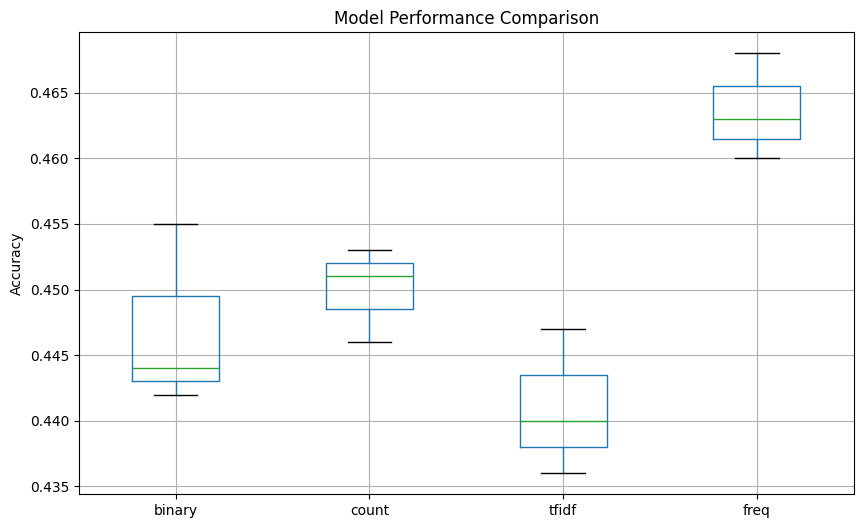

In [ ]:
# Required imports
from numpy import array
import numpy
from string import punctuation
from os import listdir
from collections import Counter
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from pandas import DataFrame
from matplotlib import pyplot
import random
import nltk

# Download required NLTK data
nltk.download('stopwords')

def load_doc(filename):
    """Load document from file"""
    with open(filename, 'r') as file:
        text = file.read()
    return text

def save_list(lines, filename):
    """Save list to file"""
    data = '\n'.join(lines)
    with open(filename, 'w') as file:
        file.write(data)

def load_doc_lines(filename):
    """Load document as lines"""
    lines = []
    with open(filename, 'rt') as file:
        for line in file:
            if not line:
                break
            lines.append(line.strip("\n"))
    return lines

def clean_doc(doc):
    """Clean document text"""
    # Split into tokens by white space
    tokens = doc.split()
    # Convert to lower case
    tokens = [word.lower() for word in tokens]
    # Remove punctuation
    table = str.maketrans('', '', punctuation)
    tokens = [w.translate(table) for w in tokens]
    # Remove non-alphabetic tokens
    tokens = [word for word in tokens if word.isalpha()]
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if w not in stop_words]
    # Remove short tokens
    tokens = [word for word in tokens if len(word) > 1]
    return tokens

def add_doc_to_vocab(filename, vocab):
    """Add document words to vocabulary"""
    doc = load_doc(filename)
    tokens = clean_doc(doc)
    vocab.update(tokens)

def doc_to_line(doc, vocab):
    """Convert document to line of tokens"""
    tokens = clean_doc(doc)
    tokens = [w for w in tokens if w in vocab]
    return ' '.join(tokens)

def process_docs(files, vocab):
    """Process all documents"""
    lines = []
    for doc in files:
        line = doc_to_line(doc, vocab)
        lines.append(line)
    return lines

def random_sample(num1, num2):
    """Split data into train and test sets"""
    dataList = list(range(num1))
    TrainIndex = []
    for i in range(num2):
        randIndex = int(random.uniform(0, len(dataList)))
        TrainIndex.append(dataList[randIndex])
        del(dataList[randIndex])
    return TrainIndex, dataList

def evaluate_mode(Xtrain, ytrain, Xtest, ytest):
    """Evaluate neural network model with multiple runs"""
    scores = []
    n_repeats = 3 #ideally it is 30
    n_words = Xtest.shape[1]

    for i in range(n_repeats):
        # Define network
        model = Sequential()
        model.add(Dense(50, input_shape=(n_words,), activation='relu'))
        model.add(Dense(5, activation='softmax'))

        # Compile network
        model.compile(loss='categorical_crossentropy',
                     optimizer='adam',
                     metrics=['accuracy'])

        # Fit network
        model.fit(Xtrain, ytrain, epochs=15, verbose=2)

        # Evaluate
        loss, acc = model.evaluate(Xtest, ytest, verbose=0)
        scores.append(acc)
        print(f'Run {i+1} accuracy: {acc:.4f}')

    return scores

def prepare_data(train_docs, test_docs, mode):
    """Prepare bag of words encoding of docs"""
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(train_docs)
    Xtrain = tokenizer.texts_to_matrix(train_docs, mode=mode)
    Xtest = tokenizer.texts_to_matrix(test_docs, mode=mode)
    return Xtrain, Xtest

# Build vocabulary
vocab = Counter()
add_doc_to_vocab(data_path + data_train_reviews, vocab)
print(f"Vocabulary size: {len(vocab)}")
print("Top 50 words:", vocab.most_common(50))

# Filter vocabulary
min_occurrence = 2
tokens = [k for k,c in vocab.items() if c >= min_occurrence]
print(f"Filtered vocabulary size: {len(tokens)}")

# Save and load vocabulary
save_list(tokens, 'vocab.txt')
vocab = set(load_doc('vocab.txt').split())

# Load training and test sets
ArRe_train_lines = load_doc_lines(data_path + data_train_reviews)
ArRa_train_lines = numpy.loadtxt(data_path + data_train_ratings, dtype=float)
ArRe_test_lines = load_doc_lines(data_path + data_test_reviews)
ArRa_test_lines = numpy.loadtxt(data_path + data_test_ratings, dtype=float)

# Process documents
train_docs = process_docs(ArRe_train_lines, vocab)
test_docs = process_docs(ArRe_test_lines, vocab)

# Prepare labels
ytrain = array(ArRa_train_lines) - 1
ytest = array(ArRa_test_lines) - 1
ytrain = to_categorical(ytrain)
ytest = to_categorical(ytest)

# Evaluate different modes
modes = ['binary', 'count', 'tfidf', 'freq']
results = DataFrame()

for mode in modes:
    print(f'\nEvaluating {mode} mode:')
    # Prepare data for mode
    Xtrain, Xtest = prepare_data(train_docs, test_docs, mode)
    # Evaluate model on data for mode
    results[mode] = evaluate_mode(Xtrain, ytrain, Xtest, ytest)

# Summarize results
print("\nStatistical Summary:")
print(results.describe())

# Plot results
pyplot.figure(figsize=(10, 6))
results.boxplot()
pyplot.title('Model Performance Comparison')
pyplot.ylabel('Accuracy')
pyplot.show()

 binary      count      tfidf       freq

count  30.000000  30.000000  30.000000  30.000000

mean    0.441367   0.444067   0.433767   0.478333

std     0.005288   0.005245   0.006678   0.005365

min     0.431000   0.430000   0.418000   0.467000

25%     0.437500   0.441000   0.429250   0.474250

50%     0.441500   0.444000   0.434500   0.478000

75%     0.445750   0.447000   0.437750   0.482000

max     0.450000   0.455000   0.452000   0.487000

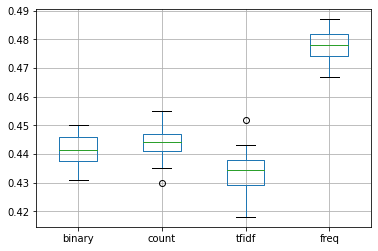
